In [3]:
import os
import math
from typing import List, Tuple

import numpy as np
import pandas as pd
from PIL import Image, ImageDraw, ImageOps


class App:
    def __init__(self,
                 image_dir_path: str,
                 target_image_name: str,
                 target_size: int,
                 num_points: int):
        
        self.target_image_path = os.path.join(image_dir_path, target_image_name)
        self.target_size = target_size
        self.num_points = num_points

        self.target_image = None
        self.target_image_vec_repr = None
        self.read_and_preprocess_image()

        self.basis_vectors_df = None
        self.get_basis_vectors()

        self.coordinates_history = []
        self

    def _convert_image_to_array(self, img: Image) -> np.ndarray:
        img_arr = np.array(img).flatten()
        img_arr = 255 - img_arr # 計算の都合上グレイスケールを反転させる
        return img_arr 


    def _recover_image_from_array(self, img_arr: np.ndarray, target_size) -> Image:
        img_arr = 255 - img_arr
        img = Image.fromarray(img_arr.reshape(target_size, target_size))
        return img

    def read_and_preprocess_image(self) -> None:
        # 画像を読み込み
        img = Image.open(self.target_image_path)

        # 画像をグレースケールに変換
        img = img.convert('L')

        # 画像を正方形に切り抜く
        size = min(img.size)
        img = ImageOps.fit(img, (size, size), Image.LANCZOS)

        # 円形に切り抜くためのマスクを作成
        mask = Image.new('L', (size, size), 0)
        draw = ImageDraw.Draw(mask)
        draw.ellipse((0, 0, size, size), fill=255)

        # マスクを使って画像を円形に切り抜く
        img = Image.composite(img, Image.new('L', img.size, 255), mask)

        # 指定されたサイズにリサイズ
        img = img.resize((self.target_size, self.target_size), Image.LANCZOS)

        self.target_image = img
        self.target_image_vec_repr = self._convert_image_to_array(img)
        
    def _approximate_circle_points(self, target_size: int, num_points: int) -> List[Tuple[int]]:
        # 正方形に内接する円の中心座標と半径を計算
        center = (target_size // 2, target_size // 2)
        radius = target_size // 2

        points = []
        for i in range(num_points):
            angle = (2 * math.pi * i) / num_points
            x = center[0] + int(radius * math.cos(angle))
            y = center[1] + int(radius * math.sin(angle))
            points.append((x, y))

        return points

    def _get_all_combinations(self, points: List[Tuple[int]]) -> List[Tuple[Tuple[int], Tuple[int]]]:
        combinations = []

        for i in range(len(points)):
            for j in range(i + 1, len(points)):
                combinations.append((points[i], points[j]))

        return combinations

    def get_basis_vectors(self) -> None:
        circle_points = self._approximate_circle_points(self.target_size, self.num_points)
        coordinates_combinations = self._get_all_combinations(circle_points)

        vector_representations = []

        for combination in coordinates_combinations:
            img = Image.new('L', (self.target_size, self.target_size), 255)
            draw = ImageDraw.Draw(img)
            draw.line(combination, fill=0, width=1)

            vector_representations.append(self._convert_image_to_array(img))

        basis_vectors_dict = {
            "coords": coordinates_combinations,
            "vec_repr": vector_representations
        }

        self.basis_vectors_df = pd.DataFrame(basis_vectors_dict)

    



image_dir_path = './../images'
target_image_name = 'eye.jpg'
target_size = 300
num_points = 100

app = App(image_dir_path, target_image_name, target_size, num_points)

In [4]:
app.basis_vectors_df

,coords,vec_repr
0,"((300, 150), (299, 159))","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"((300, 150), (298, 168))","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"((300, 150), (297, 178))","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"((300, 150), (295, 187))","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"((300, 150), (292, 196))","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
4945,"((295, 113), (298, 132))","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4946,"((295, 113), (299, 141))","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4947,"((297, 122), (298, 132))","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4948,"((297, 122), (299, 141))","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [5]:
app.target_image_vec_repr

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

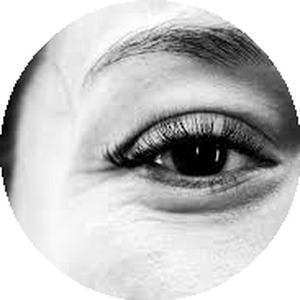

In [6]:
app.target_image

In [17]:
from typing import Tuple

class BasisVector:
    def __init__(self, 
                 pair_ids: Tuple[int],
                 pair_coordinates: Tuple[Tuple[int]]):
        self.pair_ids = pair_ids
        self.pair_coordinates = pair_coordinates
        self.vector_representation = self._get_vector_representation()

    def _get_vector_representation(self):
git
    def __add__
        

KeyError: '1'

In [37]:
arr = np.random.rand(100)
arr

array([0.48580005, 0.67472957, 0.92075062, 0.64498423, 0.33487187,
       0.15437444, 0.56338156, 0.20663089, 0.17266157, 0.941636  ,
       0.31395996, 0.54698559, 0.97071227, 0.4652353 , 0.73039495,
       0.65757293, 0.06565675, 0.06547045, 0.05046625, 0.17006609,
       0.74097069, 0.19660062, 0.9932546 , 0.92556708, 0.41653355,
       0.57447264, 0.44293984, 0.48944576, 0.94775098, 0.66036272,
       0.61658173, 0.32771982, 0.39522731, 0.63698383, 0.10929576,
       0.61206135, 0.42516551, 0.41675961, 0.53712592, 0.18649455,
       0.91394124, 0.49810321, 0.37033193, 0.02776645, 0.82603941,
       0.94644916, 0.68946806, 0.16470394, 0.02337196, 0.77382914,
       0.70029054, 0.99744931, 0.37205014, 0.88876253, 0.48512958,
       0.41763813, 0.56284729, 0.74045786, 0.583507  , 0.70551996,
       0.9779364 , 0.27397147, 0.61112194, 0.94483965, 0.76464776,
       0.21839611, 0.1696806 , 0.92369161, 0.94467336, 0.14358626,
       0.91180924, 0.92999028, 0.48658005, 0.78506243, 0.99672

In [38]:
arr.reshape(10, 10)

array([[0.48580005, 0.67472957, 0.92075062, 0.64498423, 0.33487187,
        0.15437444, 0.56338156, 0.20663089, 0.17266157, 0.941636  ],
       [0.31395996, 0.54698559, 0.97071227, 0.4652353 , 0.73039495,
        0.65757293, 0.06565675, 0.06547045, 0.05046625, 0.17006609],
       [0.74097069, 0.19660062, 0.9932546 , 0.92556708, 0.41653355,
        0.57447264, 0.44293984, 0.48944576, 0.94775098, 0.66036272],
       [0.61658173, 0.32771982, 0.39522731, 0.63698383, 0.10929576,
        0.61206135, 0.42516551, 0.41675961, 0.53712592, 0.18649455],
       [0.91394124, 0.49810321, 0.37033193, 0.02776645, 0.82603941,
        0.94644916, 0.68946806, 0.16470394, 0.02337196, 0.77382914],
       [0.70029054, 0.99744931, 0.37205014, 0.88876253, 0.48512958,
        0.41763813, 0.56284729, 0.74045786, 0.583507  , 0.70551996],
       [0.9779364 , 0.27397147, 0.61112194, 0.94483965, 0.76464776,
        0.21839611, 0.1696806 , 0.92369161, 0.94467336, 0.14358626],
       [0.91180924, 0.92999028, 0.4865800